In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

# Analyse descriptive

Ce projet vise à développer un système de classification intelligent des restaurants de Philadelphia à partir des données Yelp. L'objectif est d'aller au-delà des simples notes moyennes pour identifier différents profils de restaurants selon leur notoriété, leur positionnement et leur clientèle.

Avant de faire quoique ce soit, il est essentiel que nous ayons une vision globale de la structure de nos données. Nous disposons de 5 datasets :

- philly_business
- philly_reviews
- philly_users
- philly_tips
- philly_photos

Les conclusions tirés de cette exploration guideront le choix des variables.

## Avant filtrage

### Chargement des fichiers

In [19]:
files_to_check = [
    'data/philly_restaurants.json',
    'data/philly_restaurant_reviews.json',
    'data/philly_restaurant_users.json',
    'data/philly_restaurant_tips.json',
    'data/photos.json'
]

# Charger chaque fichier
with open(files_to_check[0], 'r', encoding='utf-8') as f:
    business = [json.loads(line) for line in f]

with open(files_to_check[1], 'r', encoding='utf-8') as f:
    reviews = [json.loads(line) for line in f]

with open(files_to_check[2], 'r', encoding='utf-8') as f:
    users = [json.loads(line) for line in f]

with open(files_to_check[3], 'r', encoding='utf-8') as f:
    tips = [json.loads(line) for line in f]

with open(files_to_check[4], 'r', encoding='utf-8') as f:
    photos = [json.loads(line) for line in f]

## Fichier Business

In [20]:
df_business = pd.DataFrame(business)

### Structure du dataset

In [21]:
print(f"\nNombre de business : {len(df_business)}")
print(f"\nColonnes disponibles :")
print(df_business.columns.tolist())
print(f"\nAperçu des premières lignes :")
print(df_business.head(3))


Nombre de business : 5852

Colonnes disponibles :
['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']

Aperçu des premières lignes :
              business_id                name        address          city  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries    935 Race St  Philadelphia   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar    205 Race St  Philadelphia   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP  1224 South St  Philadelphia   

  state postal_code   latitude  longitude  stars  review_count  is_open  \
0    PA       19107  39.955505 -75.155564    4.0            80        1   
1    PA       19106  39.953949 -75.143226    4.0           245        1   
2    PA       19147  39.943223 -75.162568    4.5           205        1   

                                          attributes  \
0  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
1  {'RestaurantsReservation

### Statistiques descriptives

In [22]:
# Notes
print(f"\n Notes (stars) :")
print(df_business['stars'].describe())

# Review count
print(f"\n Nombre de reviews par business :")
print(df_business['review_count'].describe())

# Statut (ouvert/fermé)
if 'is_open' in df_business.columns:
    print(f"\n Statut des business :")
    print(df_business['is_open'].value_counts())
    print(f"  Ouverts : {(df_business['is_open']==1).sum()}")
    print(f"  Fermés : {(df_business['is_open']==0).sum()}")


 Notes (stars) :
count    5852.000000
mean        3.555964
std         0.803122
min         1.000000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: stars, dtype: float64

 Nombre de reviews par business :
count    5852.000000
mean      113.761449
std       241.378560
min         5.000000
25%        14.000000
50%        38.500000
75%       114.000000
max      5721.000000
Name: review_count, dtype: float64

 Statut des business :
is_open
1    3525
0    2327
Name: count, dtype: int64
  Ouverts : 3525
  Fermés : 2327


Pour les notes, la médiane est plus haute que la moyenne. Il y a donc une asymétrie à gauche. Beaucoup de commerces sont notés 4+. Les très mauvaises notes tirent la moyenne vers le bas. La note moyenne seule ne va pas nous permettre de caractériser un commerce. La variance et ratio de notes positive ou négative seront plus parlants que les notes en elle-même.

Le nombre de reviews varie significativement en fonction du commerce. Il sera préférable d'utiliser log_review_count plutot que la variable brute.

On a 10 542 commerces d'ouverts contre 4027 fermés soit 72%. Ce pourcentage est assez grand pour qu'on se permette de supprimer les commerces fermés.

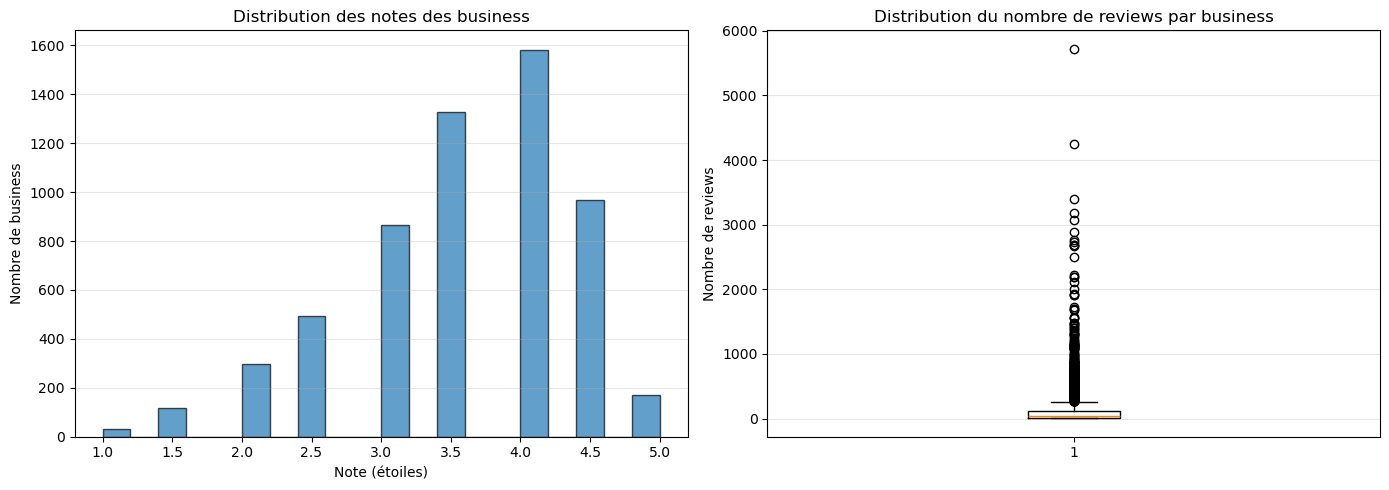

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des notes
axes[0].hist(df_business['stars'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Note (étoiles)')
axes[0].set_ylabel('Nombre de business')
axes[0].set_title('Distribution des notes des business')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot review count
axes[1].boxplot(df_business['review_count'])
axes[1].set_ylabel('Nombre de reviews')
axes[1].set_title('Distribution du nombre de reviews par business')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Fichier Reviews

In [24]:
df_reviews = pd.DataFrame(reviews)

In [25]:
print(f"\nNombre de reviews : {len(df_reviews)}")
print(f"\nColonnes disponibles :")
print(df_reviews.columns.tolist())
print(f"\nAperçu des premières lignes :")
print(df_reviews.head(3))


Nombre de reviews : 687289

Colonnes disponibles :
['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

Aperçu des premières lignes :
                review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  JrIxlS1TzJ-iCu79ul40cQ  eUta8W_HdHMXPzLBBZhL1A  04UD14gamNjLY0IDYVhHJg   
2  8JFGBuHMoiNDyfcxuWNtrA  smOvOajNG0lS4Pq7d8g4JQ  RZtGWDLCAtuipwaZ-UfjmQ   

   stars  useful  funny  cool  \
0    5.0       1      0     1   
1    1.0       1      2     1   
2    4.0       0      0     0   

                                                text                 date  
0  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03  
1  I am a long term frequent customer of this est...  2015-09-23 23:10:31  
2  Good food--loved the gnocchi with marinara\nth...  2009-10-14 19:57:14  


### Statitistiques descriptives

In [26]:
# Distribution des notes
print(f"\n Distribution des notes :")
print(df_reviews['stars'].value_counts().sort_index())

# Statistiques sur useful, funny, cool
print(f"\n Votes 'useful' :")
print(df_reviews['useful'].describe())

print(f"\n Votes 'funny' :")
print(df_reviews['funny'].describe())

print(f"\n Votes 'cool' :")
print(df_reviews['cool'].describe())

# Longueur des reviews
df_reviews['text_length'] = df_reviews['text'].str.len()
print(f"\n Longueur des reviews (caractères) :")
print(df_reviews['text_length'].describe())


 Distribution des notes :
stars
1.0     66624
2.0     57480
3.0     91702
4.0    194366
5.0    277117
Name: count, dtype: int64

 Votes 'useful' :
count    687289.000000
mean          1.101761
std           2.531508
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         224.000000
Name: useful, dtype: float64

 Votes 'funny' :
count    687289.000000
mean          0.370848
std           1.430542
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         227.000000
Name: funny, dtype: float64

 Votes 'cool' :
count    687289.000000
mean          0.550538
std           1.850401
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         163.000000
Name: cool, dtype: float64

 Longueur des reviews (caractères) :
count    687289.000000
mean        601.861687
std         532.965631
min           1.000000
25%         246.000000
50%         443.000000
75%  

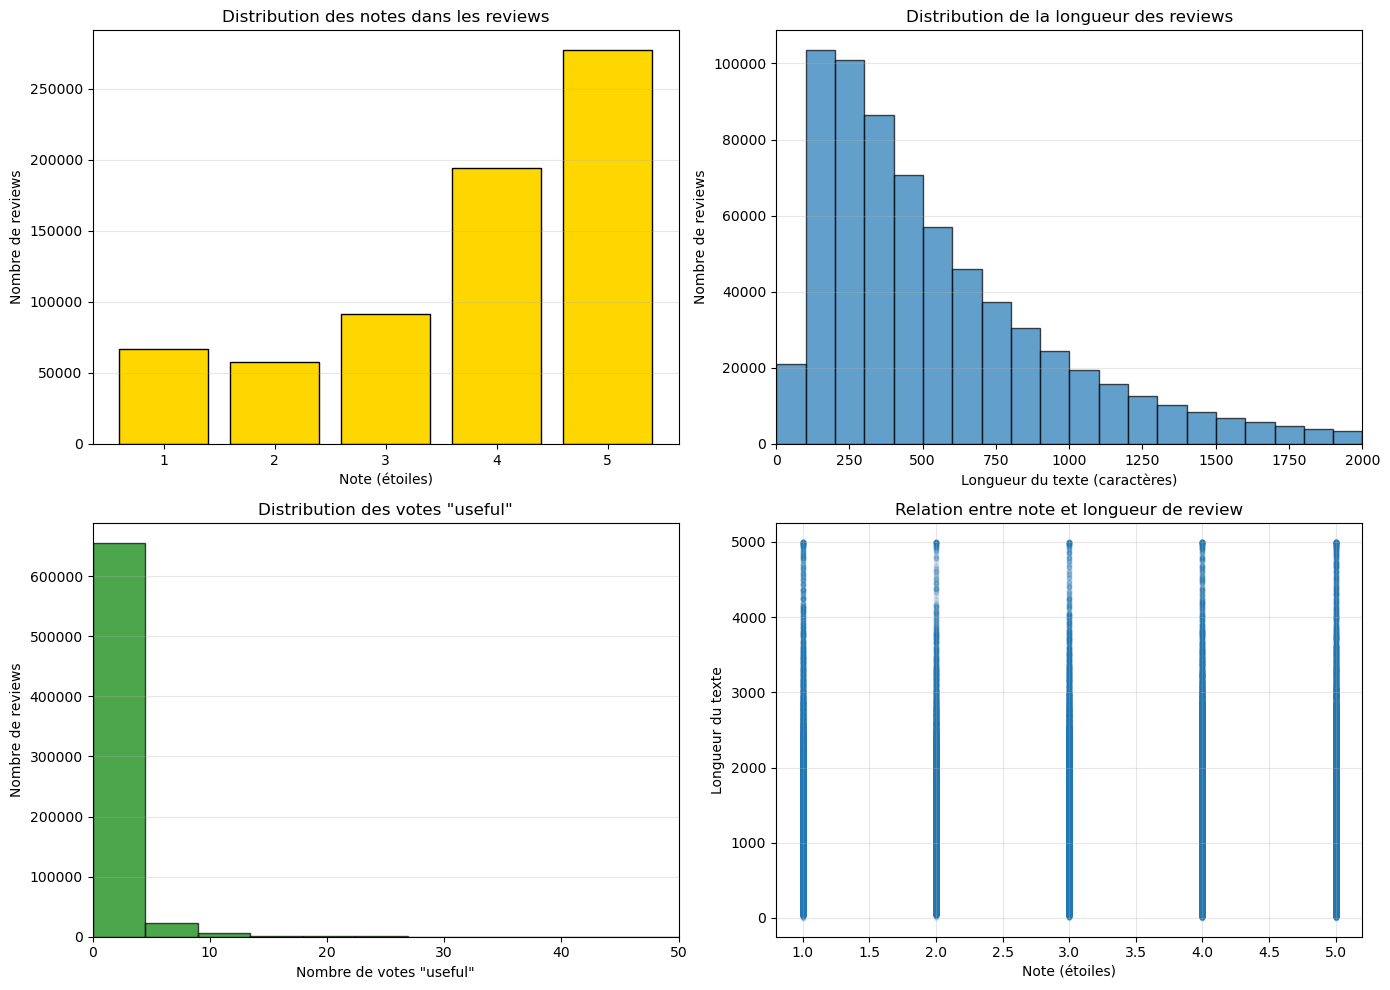

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution des notes
star_counts = df_reviews['stars'].value_counts().sort_index()
axes[0, 0].bar(star_counts.index, star_counts.values, color='gold', edgecolor='black')
axes[0, 0].set_xlabel('Note (étoiles)')
axes[0, 0].set_ylabel('Nombre de reviews')
axes[0, 0].set_title('Distribution des notes dans les reviews')
axes[0, 0].grid(axis='y', alpha=0.3)

# Longueur des textes
axes[0, 1].hist(df_reviews['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Longueur du texte (caractères)')
axes[0, 1].set_ylabel('Nombre de reviews')
axes[0, 1].set_title('Distribution de la longueur des reviews')
axes[0, 1].set_xlim(0, 2000)
axes[0, 1].grid(axis='y', alpha=0.3)

# Votes useful
axes[1, 0].hist(df_reviews['useful'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Nombre de votes "useful"')
axes[1, 0].set_ylabel('Nombre de reviews')
axes[1, 0].set_title('Distribution des votes "useful"')
axes[1, 0].set_xlim(0, 50)
axes[1, 0].grid(axis='y', alpha=0.3)

# Corrélation note vs longueur
axes[1, 1].scatter(df_reviews['stars'], df_reviews['text_length'], alpha=0.1, s=10)
axes[1, 1].set_xlabel('Note (étoiles)')
axes[1, 1].set_ylabel('Longueur du texte')
axes[1, 1].set_title('Relation entre note et longueur de review')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Les utilisateurs ont tendance à laisser des avis soit très positifs (4-5 étoiles = 68%) soit très négatifs (1-2 étoiles = 20%). Ce n'est vraiment pas surprenant comme les expériences moyennes entrainent souvent moins d'engagement.

 La majorité des reviews (plus de 50%) ne reçoivent aucun vote "useful", suggérant que beaucoup de contenu passe inaperçu. De même, la grande majorité des reviews ne sont ni perçues comme drôles ni perçues comme cool. Etant donné que plus de de 50% des reviews ont 0 votes funny, cool et useful, il faudra éviter d'utiliser cette variable dans notre clustering.

## Fichier users

In [28]:
df_users = pd.DataFrame(users)

In [29]:
print(f"\nNombre d'utilisateurs : {len(df_users)}")
print(f"\nColonnes disponibles :")
print(df_users.columns.tolist())
print(f"\nAperçu des premières lignes :")
print(df_users.head(3))


Nombre d'utilisateurs : 209513

Colonnes disponibles :
['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']

Aperçu des premières lignes :
                  user_id    name  review_count        yelping_since  useful  \
0  qVc8ODYU5SZjKXVBgXdI7w  Walker           585  2007-01-25 16:47:26    7217   
1  j14WgRoU_-2ZE1aw1dXrJg  Daniel          4333  2009-01-25 04:35:42   43091   
2  q_QQ5kBBwlCcbL1s4NVK3g    Jane          1221  2005-03-14 20:26:35   14953   

   funny   cool                                              elite  \
0   1259   5994                                               2007   
1  13066  27281  2009,2010,2011,2012,2013,2014,2015,2016,2017,2...   
2   9940  11211       2006,2007,2008,200

### Statistiques descriptives

In [30]:
print(f"\n Nombre de reviews par utilisateur :")
print(df_users['review_count'].describe())

print(f"\n Moyenne des étoiles données :")
print(df_users['average_stars'].describe())

print(f"\n Nombre d'amis :")
if 'friends' in df_users.columns:
    df_users['friends_count'] = df_users['friends'].apply(lambda x: len(x.split(',')) if x != 'None' else 0)
    print(df_users['friends_count'].describe())

print(f"\n Statut Elite :")
if 'elite' in df_users.columns:
    df_users['is_elite'] = df_users['elite'].apply(lambda x: x != 'None' and x != '')
    print(f"  Utilisateurs Elite : {df_users['is_elite'].sum()}")
    print(f"  Utilisateurs non-Elite : {(~df_users['is_elite']).sum()}")


 Nombre de reviews par utilisateur :
count    209513.000000
mean         45.838287
std         156.565449
min           0.000000
25%           3.000000
50%           9.000000
75%          30.000000
max       17473.000000
Name: review_count, dtype: float64

 Moyenne des étoiles données :
count    209513.000000
mean          3.703596
std           0.999049
min           1.000000
25%           3.250000
50%           3.880000
75%           4.380000
max           5.000000
Name: average_stars, dtype: float64

 Nombre d'amis :
count    209513.000000
mean         69.902846
std         207.278820
min           0.000000
25%           0.000000
50%           4.000000
75%          66.000000
max       14995.000000
Name: friends_count, dtype: float64

 Statut Elite :
  Utilisateurs Elite : 20557
  Utilisateurs non-Elite : 188956


La grande majorité d'utilisateurs sont occasionnels. On observe que 50% ont moins de 7 reviews, 75% ont moins de 24 reviews. Cela montre que c'est la petite minorité d'utilisateurs hyperactifs qui tirent la moyenne vers le haut. Il ya quelques contributeurs produisent l'essentiel du contenu.

Les reviews d'utilisateurs avec une ou deux reviews peuvent être moins fiables. Les utilisateurs hyperactifs (qui ont plus de 100 reviews) ont plus de crédibilité mais peuvent avoir des biais. De plus, on remarque que les utilisateurs sont globalement plus gentils que sévères

25% des utilisateurs ont 0 ami, 50% ont moins de 3 amis ce qui révèle un comportement individuel. La plateforme semble être utilisée principalement comme outil de recherche/avis, pas comme réseau social. Utiliser la variable friends ne serait donc pas pertinant pour faire du clustering.

Les utilisateurs Elite sont une minorité engagée et reconnue par Yelp. Les revues de ces utilisateurs peuvent être plus stables et détaillés.

On pourrait utiliser les variables "compliment" pour essayer de construire un score de popularité des users.

## Fichier Photo

In [31]:
df_photos = pd.DataFrame(photos)

In [32]:
print(f"\nNombre de photos : {len(df_photos)}")
print(f"\nColonnes disponibles :")
print(df_photos.columns.tolist())
print(f"\nAperçu des premières lignes :")
print(df_photos.head(3))



Nombre de photos : 200100

Colonnes disponibles :
['photo_id', 'business_id', 'caption', 'label']

Aperçu des premières lignes :
                 photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  


### Statistiques descriptives

In [33]:
# Types de photos (labels)
if 'label' in df_photos.columns:
    print(f"\n Types de photos :")
    print(df_photos['label'].value_counts())


 Types de photos :
label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


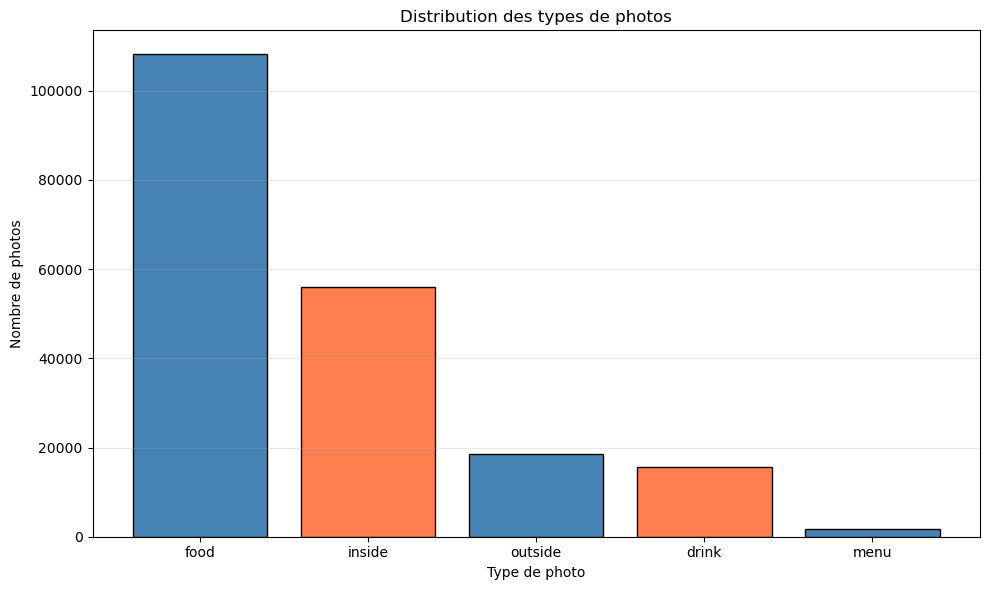

In [34]:
if 'label' in df_photos.columns:
    label_counts = df_photos['label'].value_counts()

    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.index, label_counts.values, color=['steelblue', 'coral'], edgecolor='black')
    plt.xlabel('Type de photo')
    plt.ylabel('Nombre de photos')
    plt.title('Distribution des types de photos')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


Plus de la moitié des photos montrent la nourriture. Inside reflète l'ambiance, la décoration et l'atmosphère du business. Dans la catégorie "outside", il y a 4x moins de photos que "inside". Les menus représente seulement 1% des photos ce qui est vraiment dommage car ils nous auraient permis de déterminer un prix moyen par business. Cette variable aurait pu être très intéressantes pour un clustering.

## Après filtrage

Pour la suite de cette étude, on a choisi de ne pas utiliser le fichier Tips car ils comportent également des reviews. On va filtrer par restaurants et retirer les commerces fermés.

In [35]:
print("Avant filtrage:")
print(f"Businesses: {len(df_business)}")
print(f"Reviews: {len(df_reviews)}")
print(f"Photos: {len(df_photos)}")

# Filtrer les restaurants ouverts uniquement
df_restaurants_filtered = df_business[
    (df_business['categories'].notna()) &  # A des catégories
    (df_business['categories'].str.contains('Restaurant', case=False, na=False)) &  # Est un restaurant
    (df_business['is_open'] == 1)  # Est ouvert
].copy()

print(f"\nRestaurants ouverts: {len(df_restaurants_filtered)}")

# Récupérer les IDs des restaurants filtrés
valid_business_ids = set(df_restaurants_filtered['business_id'])

# Filtrer les autres datasets pour ne garder que les données liées à ces restaurants
df_reviews_filtered = df_reviews[df_reviews['business_id'].isin(valid_business_ids)].copy()
df_photos_filtered = df_photos[df_photos['business_id'].isin(valid_business_ids)].copy()

# Note: on garde tous les users pour l'instant, on pourrait filtrer plus tard si besoin

print("\nAprès filtrage (restaurants ouverts uniquement):")
print(f"Restaurants: {len(df_restaurants_filtered)}")
print(f"Reviews: {len(df_reviews_filtered)}")
print(f"Photos: {len(df_photos_filtered)}")

Avant filtrage:
Businesses: 5852
Reviews: 687289
Photos: 200100

Restaurants ouverts: 3525

Après filtrage (restaurants ouverts uniquement):
Restaurants: 3525
Reviews: 511138
Photos: 17407


In [36]:
print(f"Nombre de restaurants ouverts: {len(df_restaurants_filtered):,}")
print(f"Nombre de reviews: {len(df_reviews_filtered):,}")
print(f"Nombre de photos: {len(df_photos_filtered):,}")
print(f"Nombre d'utilisateurs (total dataset): {len(df_users):,}")

print(f"\nMoyenne reviews par restaurant: {len(df_reviews_filtered) / len(df_restaurants_filtered):.1f}")
print(f"Moyenne photos par restaurant: {len(df_photos_filtered) / len(df_restaurants_filtered):.1f}")

Nombre de restaurants ouverts: 3,525
Nombre de reviews: 511,138
Nombre de photos: 17,407
Nombre d'utilisateurs (total dataset): 209,513

Moyenne reviews par restaurant: 145.0
Moyenne photos par restaurant: 4.9


## Statistiques sur les restaurants

### Vue globale

In [37]:
print("\n Notes (stars) ")
print(df_restaurants_filtered['stars'].describe())

print("\n Nombre de reviews par restaurant ")
print(df_restaurants_filtered['review_count'].describe())

print("\n Top 10 restaurants par nombre de reviews ")
top_reviewed = df_restaurants_filtered.nlargest(10, 'review_count')[['name', 'stars', 'review_count', 'city']]
print(top_reviewed.to_string())

print("\n Top 10 restaurants par note (min 50 reviews) ")
top_rated = df_restaurants_filtered[df_restaurants_filtered['review_count'] >= 50].nlargest(10, 'stars')[['name', 'stars', 'review_count', 'city']]
print(top_rated.to_string())


 Notes (stars) 
count    3525.000000
mean        3.585106
std         0.836943
min         1.000000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: stars, dtype: float64

 Nombre de reviews par restaurant 
count    3525.000000
mean      140.535319
std       291.768622
min         5.000000
25%        15.000000
50%        46.000000
75%       146.000000
max      5721.000000
Name: review_count, dtype: float64

 Top 10 restaurants par nombre de reviews 
                                name  stars  review_count          city
5548         Reading Terminal Market    4.5          5721  Philadelphia
4434            Pat's King of Steaks    3.0          4250  Philadelphia
2254                   Geno's Steaks    2.5          3401  Philadelphia
5111                          El Vez    4.0          3187  Philadelphia
1262                           Zahav    4.5          3065  Philadelphia
2529                        Barbuzzo    4.5          2893  Philadelphia


En faisant nos recherches, nous avons pu constater que les restaurants les plus reviewés sont principalement des institutions touristiques et des attractions culinaires emblématiques. Reading Terminal Market domine avec 5,721 reviews (c'est un marché alimentaire historique). Pat's et Geno's (qui sont des rivaux du cheesesteak) ont 7,651 reviews à eux deux, mais leurs notes sont médiocres (3.0 et 2.5). Donc, ces établissements ont une forte notoriété et un flux touristique important, mais par contre la qualité ne suit pas toujours.

Ce sont probablement des établissements de quartier ou ethniques (Polish Food Cart, Cafe Mi Quang, Tortilleria San Roman) qui ont une clientèle plus locale et fidèle. On remarque par contre que Tortilleria San Roman (qui a 219 reviews) est particulièrement intéressant car il arrive à maintenir une note parfaite malgré un volume plus élevé.

### Reviews

In [38]:
print("\n Distribution des notes dans les reviews ")
print(df_reviews_filtered['stars'].value_counts().sort_index())

# Temporalité des reviews
df_reviews_filtered['date'] = pd.to_datetime(df_reviews_filtered['date'])
print("\n Période couverte par les reviews ")
print(f"Première review: {df_reviews_filtered['date'].min()}")
print(f"Dernière review: {df_reviews_filtered['date'].max()}")

print("\n Reviews par année ")
df_reviews_filtered['year'] = df_reviews_filtered['date'].dt.year
print(df_reviews_filtered['year'].value_counts().sort_index().tail(10))


 Distribution des notes dans les reviews 
stars
1.0     48019
2.0     39352
3.0     64467
4.0    141789
5.0    217511
Name: count, dtype: int64

 Période couverte par les reviews 
Première review: 2005-02-16 04:06:26
Dernière review: 2022-01-19 19:46:34

 Reviews par année 
year
2013    33623
2014    40753
2015    48704
2016    51156
2017    55564
2018    59498
2019    62361
2020    32448
2021    36118
2022     1842
Name: count, dtype: int64


### Users

In [39]:
users_who_reviewed = df_reviews_filtered['user_id'].unique()
df_users_active = df_users[df_users['user_id'].isin(users_who_reviewed)]

print(f"\nUtilisateurs ayant reviewé ces restaurants: {len(df_users_active):,}")

print("\n Reviews par utilisateur (utilisateurs actifs) ")
print(df_users_active['review_count'].describe())

print("\n Moyenne des étoiles données par utilisateur ")
print(df_users_active['average_stars'].describe())


Utilisateurs ayant reviewé ces restaurants: 178,325

 Reviews par utilisateur (utilisateurs actifs) 
count    178325.000000
mean         49.675110
std         166.255214
min           0.000000
25%           4.000000
50%          10.000000
75%          33.000000
max       17473.000000
Name: review_count, dtype: float64

 Moyenne des étoiles données par utilisateur 
count    178325.000000
mean          3.714944
std           0.975767
min           1.000000
25%           3.270000
50%           3.880000
75%           4.370000
max           5.000000
Name: average_stars, dtype: float64


- 2013-2019 : Croissance régulière
- 2020 : Chute brutale
- 2021 : Reprise partielle
- 2022 : Données incomplètes

### Corrélation

In [40]:
# Corrélation entre note et nombre de reviews
correlation = df_restaurants_filtered[['stars', 'review_count']].corr()
print("\n Corrélation note vs nombre de reviews ")
print(correlation)


 Corrélation note vs nombre de reviews 
                stars  review_count
stars         1.00000       0.15428
review_count  0.15428       1.00000


On observe une corrélation positive faible. Ces résultats confirment les conclusions que nous avions tirés du top 10 des restaurants. Les restaurants avec plus de reviews ont légèrement tendance à être mieux notés, mais c'est loin d'être systématique.